https://github.com/openslide/openslide-python/issues/35

In [ ]:
!sudo apt-get install openslide-tools
!sudo apt-get install python-openslide
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (181 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import shutil
import os
import glob
from IPython.display import Image, display
import PIL
PIL.Image.MAX_IMAGE_PIXELS = None


import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import openslide

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.utils as ku

from sklearn.model_selection import train_test_split

In [ ]:
__zipped_dir = "/content/gdrive/MyDrive/GSoC'22 @ TensorFlow/Panda Subset 3 GB.zip"
__extract_dir = "/content/PANDA_subset"
if not os.path.exists(__extract_dir):
  os.mkdir(__extract_dir)
shutil.unpack_archive(__zipped_dir, __extract_dir, 'zip')

In [ ]:
BASE_DIR = __extract_dir
IMAGES_DIR = os.path.join(BASE_DIR, 'train_images_subset')
MASK_DIR = os.path.join(BASE_DIR, 'train_masks_subset')

In [ ]:
train_data = pd.read_csv(os.path.join(BASE_DIR, 'train_subset.csv'))
train_data.head()

,image_id,data_provider,isup_grade,gleason_score,mask_file_name
0,6f8a4164d3e4d3d168d51cc090ee7723,karolinska,0,0+0,6f8a4164d3e4d3d168d51cc090ee7723_mask.tiff
1,81adb00db7e7b3034900a1f95a4dc257,radboud,1,3+3,81adb00db7e7b3034900a1f95a4dc257_mask.tiff
2,cb88fb1e0305ba94d8186a245ac2193b,karolinska,2,3+4,cb88fb1e0305ba94d8186a245ac2193b_mask.tiff
3,a7f00efad38057d7c04273206366b682,karolinska,3,4+3,a7f00efad38057d7c04273206366b682_mask.tiff
4,fd412a8f537036702bb0e3fa3160f336,karolinska,4,4+4,fd412a8f537036702bb0e3fa3160f336_mask.tiff


In [ ]:
train_df_copy = train_data.copy()
train_df_copy['image_id'] = train_df_copy['image_id'] + '.tiff'
train_df_copy = train_df_copy.set_index('image_id')

In [ ]:
train_df, validation_df = train_test_split(train_data, test_size=0.2)

In [ ]:
train_df.reset_index(inplace=True)

In [ ]:
validation_df.reset_index(inplace=True)

In [ ]:
class EDAUtilFunctions:
    
    def __init__(self, dataframe: pd.DataFrame):
        self.df = dataframe
    
    def count_plot(self, col_names: list):
        
        plt.figure(figsize=(8,6), tight_layout=True)
        colors = sns.color_palette('pastel')
        
        for col_name in col_names:
        
            if col_name not in self.df.columns:
                raise KeyError(f'{col_name} should be present in {self.df.columns}')

            

            unique_features, counts = np.unique(self.df[col_name], return_counts=True)

            plt.bar(unique_features, counts, color=colors[:len(unique_features)])
            plt.xticks(rotation=90)
            plt.xlabel(col_name)
            plt.ylabel('Count')
            plt.title('Count Plot')
            plt.show()
    
    def funnel_plot(self, text: str, values: str):
        if text not in self.df.columns:
            raise KeyError(f'{text} should be present in {self.df.columns}')
        
        if values not in self.df.columns:
            raise KeyError(f'{values} should be present in {self.df.columns}')
        
        fig = go.Figure(go.Funnelarea(
        text =self.df[text],
        values = self.df[values],
        title = {"position": "top center", "text": "Funnel-Chart of ISUP_grade Distribution"}))
        fig.show()

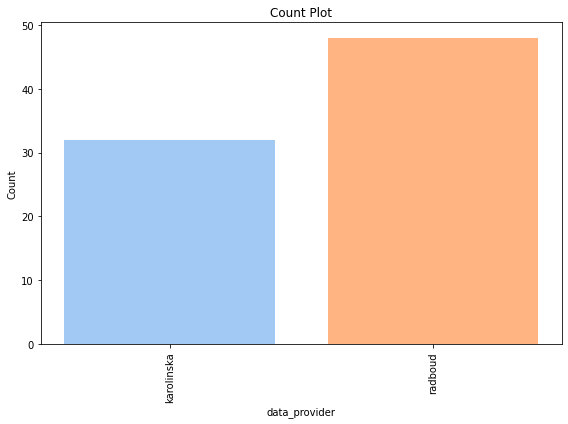

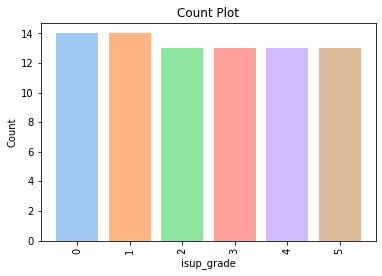

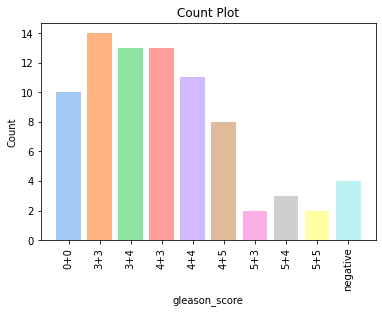

In [ ]:
eda_df = EDAUtilFunctions(train_data)
eda_df.count_plot(['data_provider', 'isup_grade', 'gleason_score'])

##  Working with the tiff files

In [ ]:
class TIFFVisualization:
    
    @staticmethod
    def visualize_patch(patch_shape: tuple, n_images: int, pos: tuple, img_dir: str, dft: pd.DataFrame, index_level: int):
        

        filenames = glob.glob(f'{img_dir}/*.tiff')
        
        if len(filenames) is 0:
            raise RuntimeError(f'{img_dir} should contain tiff encoded images')
        
        if 0 > index_level > 2:
          raise RuntimeError(f'{index_level} should be in the range [0, 2]')
        
        
        
        indices = np.random.randint(0, len(filenames), n_images)
        
        fig, axes = plt.subplots(n_images // 3, 3, figsize=(20, 60))
        for i in range(n_images):
            key_name = filenames[indices[i]].split('/')[-1]
            slide = openslide.OpenSlide(filenames[indices[i]])
            patch = slide.read_region(pos, 2, patch_shape)
            axes[i // 3][i % 3].imshow(patch)
            slide.close()       
            axes[i//3, i%3].axis('off')
            
            axes[i//3, i%3].set_title(f'image id: {key_name}\n ISUP Grade: {dft.loc[key_name].isup_grade}')
            
        
        plt.show()
    
    @staticmethod
    def visualize_masks(n_images: int, mask_dir: str, img_dir: str, dft: pd.DataFrame, 
                        max_size=(400, 400), alpha=0.8):
        
        filenames = glob.glob(f'{mask_dir}/*.tiff')
        
        if len(filenames) is 0:
            raise RuntimeError(f'{img_dir} should contain tiff encoded images')
            
        indices = np.random.randint(0, len(filenames), n_images)
        
        fig, axes = plt.subplots(n_images, 2, figsize=(10, 60))
        
        for i in range(n_images):
            key_name = filenames[indices[i]].split('/')[-1]
            key_name = key_name.replace('_mask', "")
            train_img = f'{img_dir}/{key_name}'
            
            img = openslide.OpenSlide(train_img)
            mask = openslide.OpenSlide(filenames[indices[i]])
            
            img_data = img.read_region((0,0), img.level_count - 1, img.level_dimensions[-1])
            mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
            mask_data = mask_data.split()[0]

            
            center = dft.loc[key_name]['data_provider']
            alpha_int = int(round(255*alpha))
            if center == 'radboud':
                alpha_content = np.less(mask_data.split()[0], 2).astype('uint8') * alpha_int + (255 - alpha_int)
            elif center == 'karolinska':
                alpha_content = np.less(mask_data.split()[0], 1).astype('uint8') * alpha_int + (255 - alpha_int)

            

            alpha_content = PIL.Image.fromarray(alpha_content)
            preview_palette = np.zeros(shape=768, dtype=int)

            if center == 'radboud':
                # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
                preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
            elif center == 'karolinska':
                # Mapping: {0: background, 1: benign, 2: cancer}
                preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)

            mask_data.putpalette(data=preview_palette.tolist())
            mask_rgb = mask_data.convert(mode='RGB')
            
            

            overlayed_image = PIL.Image.composite(image1=img_data, image2=mask_rgb, mask=alpha_content)

            overlayed_image.thumbnail(size=max_size, resample=0)
            
            axes[i][1].imshow(overlayed_image)
            axes[i][0].imshow(img.get_thumbnail(size=max_size))
            
            axes[i][0].axis('off')
            axes[i][1].axis('off')

            
            axes[i][0].set_title(f'image id: {key_name}\ncenter: {dft.loc[key_name].data_provider}')
            axes[i][1].set_title(f' \n ISUP Grade: {dft.loc[key_name].isup_grade}')
            
            img.close()
            mask.close()
        
        plt.show()
      
    @staticmethod
    def get_entire_slide_at_all_res(n_images: int, img_dir: str):
        filenames = glob.glob(f'{img_dir}/*.tiff')
        
        if len(filenames) is 0:
            raise RuntimeError(f'{img_dir} should contain tiff encoded images')
        
        indices = np.random.randint(0, len(filenames), n_images)

        fig, axes = plt.subplots(n_images, 3, figsize=(20, 20))

        for ind in range(n_images):
          img = openslide.OpenSlide(filenames[indices[ind]])
          print(img)
          img_data = img.read_region((0,0), 0, img.level_dimensions[0])
          axes[0].imshow(img_data)

          img_data = img.read_region((0,0), 1, img.level_dimensions[1])
          axes[1].imshow(img_data)

          img_data = img.read_region((0,0), 2, img.level_dimensions[2])
          axes[2].imshow(img_data)
          img.close()
        
        plt.show()


In [ ]:
# TIFFVisualization.get_entire_slide_at_all_res(1, IMAGES_DIR)

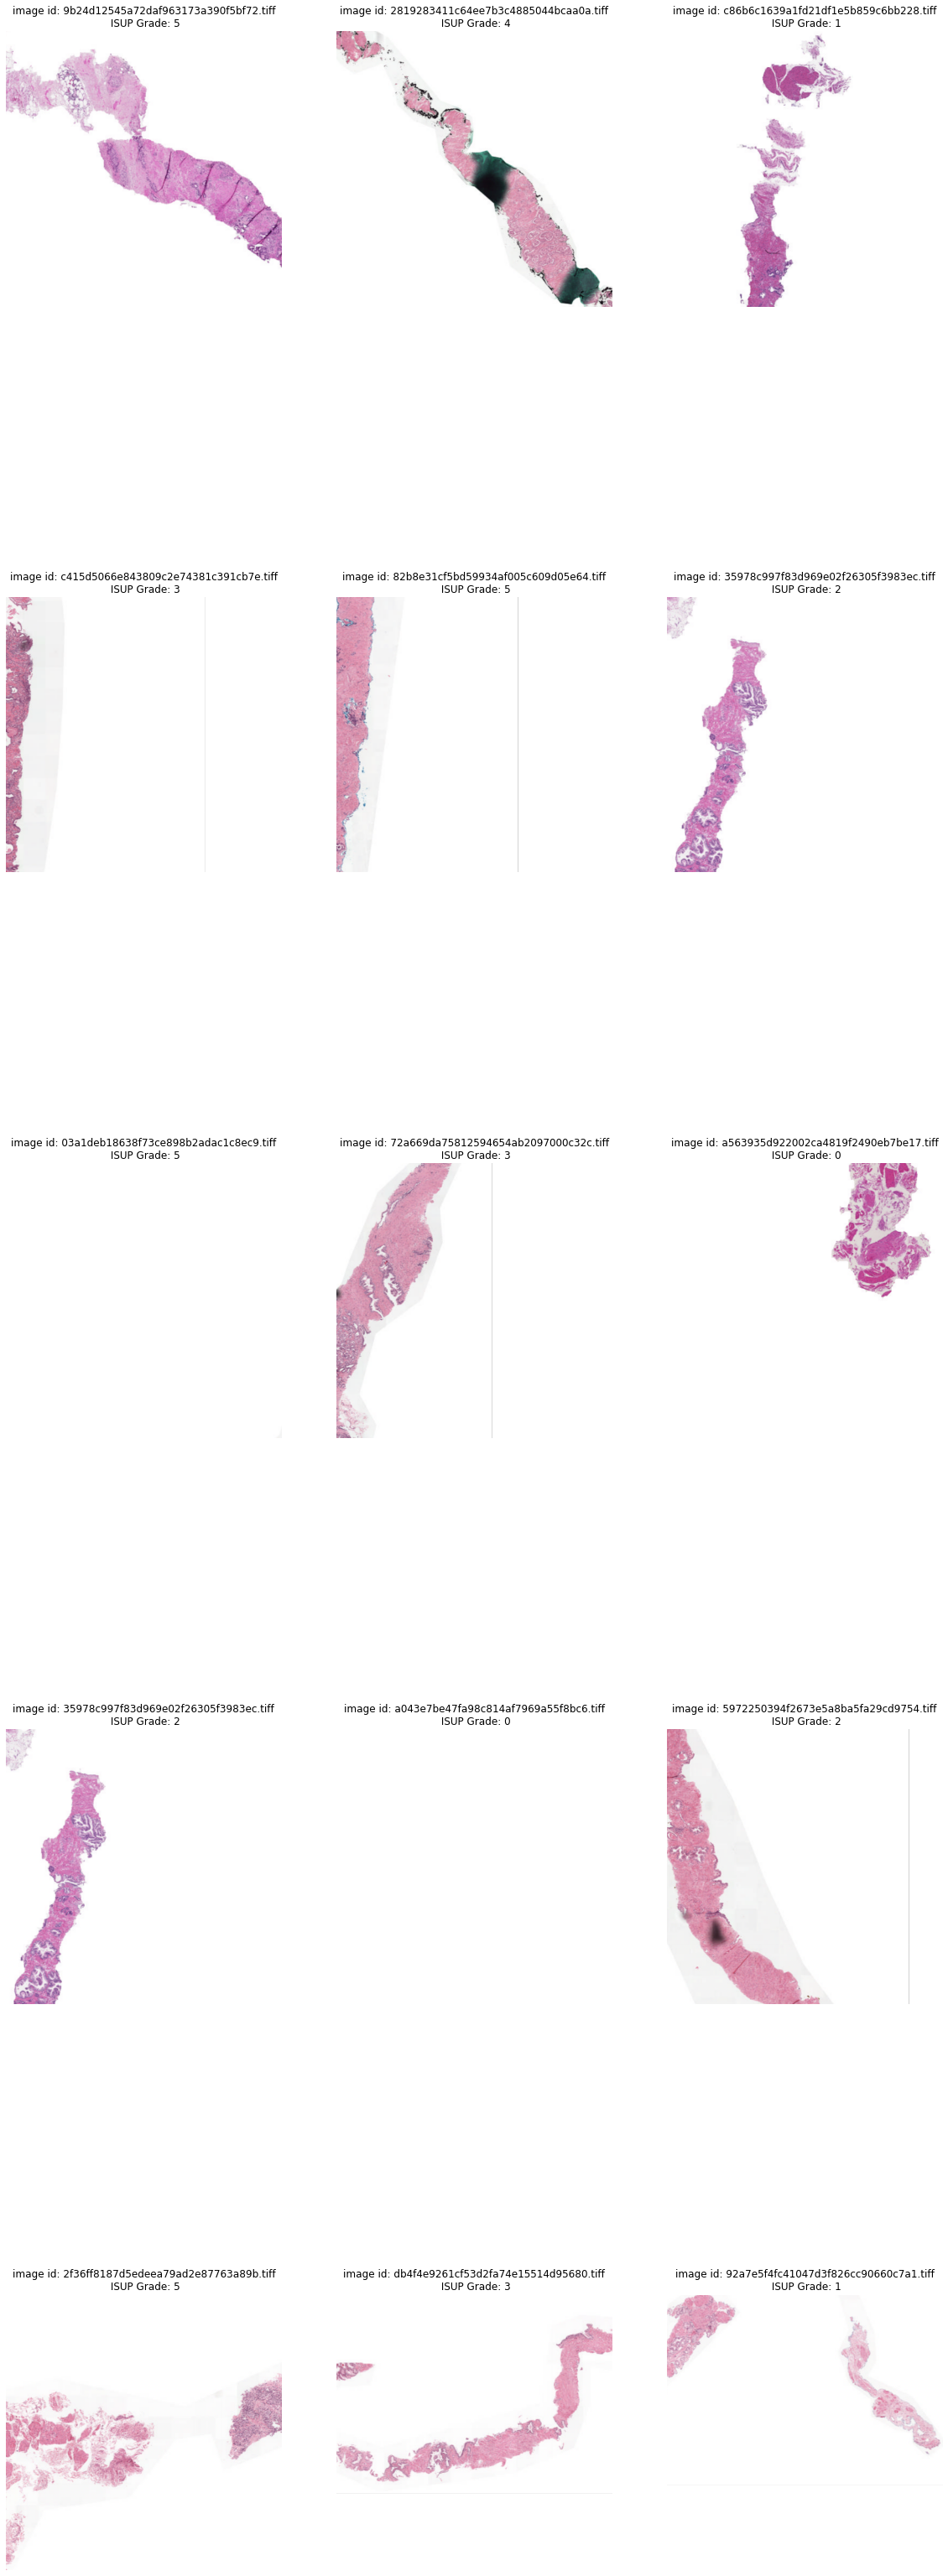

In [ ]:
TIFFVisualization.visualize_patch((512, 512), 15, np.random.randint(1759, 1800, (2,)), IMAGES_DIR, train_df_copy, 0)

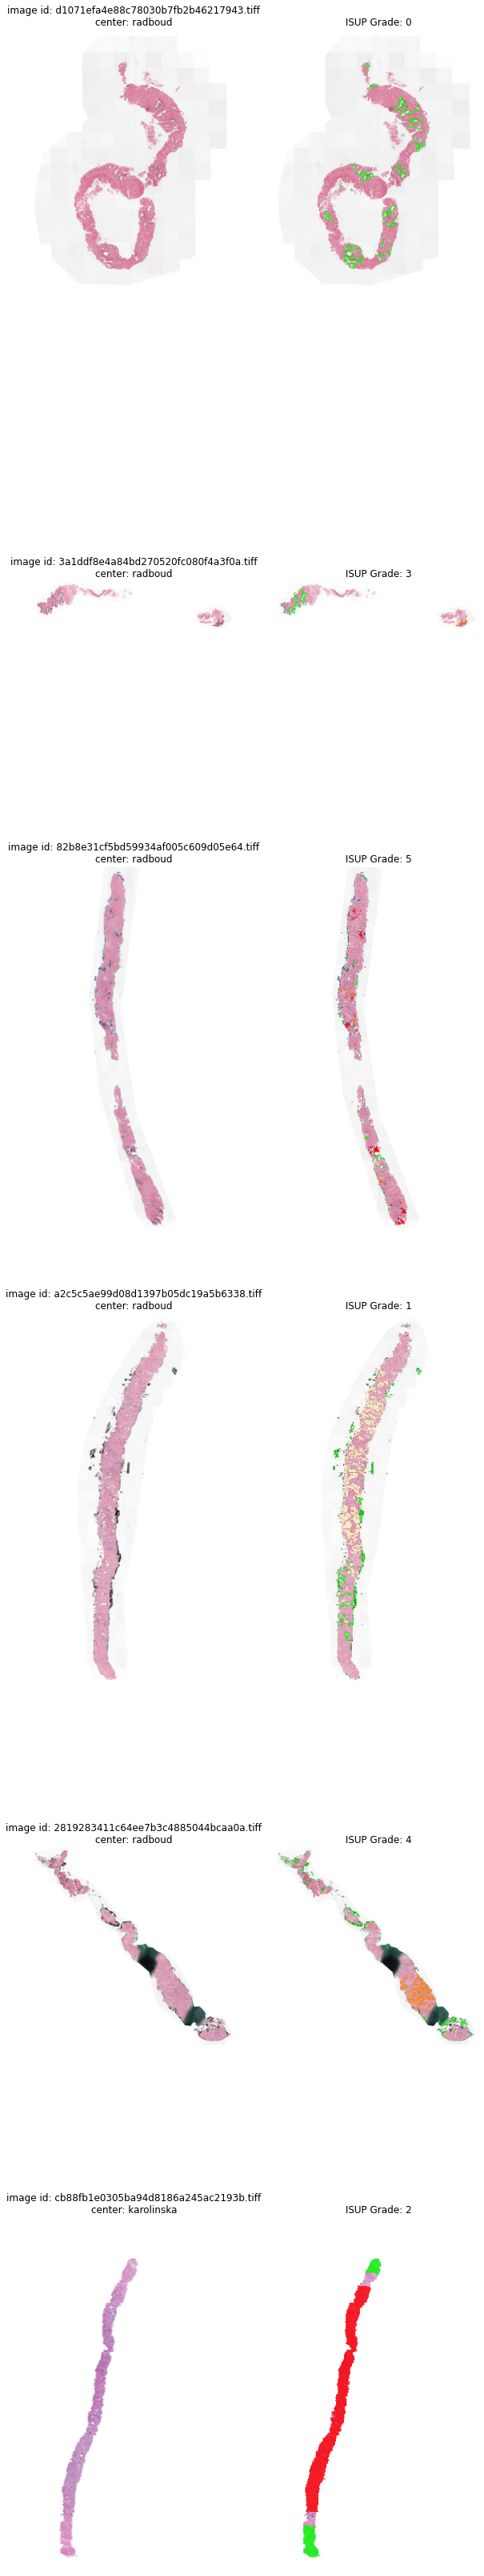

In [ ]:
TIFFVisualization.visualize_masks(6, MASK_DIR, IMAGES_DIR, train_df_copy,)

In [ ]:
img = openslide.OpenSlide('/content/PANDA_subset/train_images_subset/81adb00db7e7b3034900a1f95a4dc257.tiff')
img_data = img.read_region((0, 0), 2, img.level_dimensions[2])
img_data = img_data.convert('RGB')
img_data = np.asarray(img_data, np.float32) / 255.0

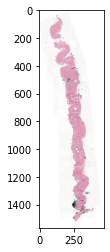

In [ ]:
plt.imshow(img_data)

In [ ]:
img_data = tf.expand_dims(img_data, 0)

In [ ]:
print(img_data.shape)

(1, 1568, 464, 3)


In [ ]:
patches = tf.image.extract_patches(img_data, (1, 128, 128, 1), (1, 128, 128, 1), (1, 1, 1, 1), 'VALID')
patches = tf.reshape(patches, (-1, 128, 128, 3))
patches.shape

TensorShape([36, 128, 128, 3])

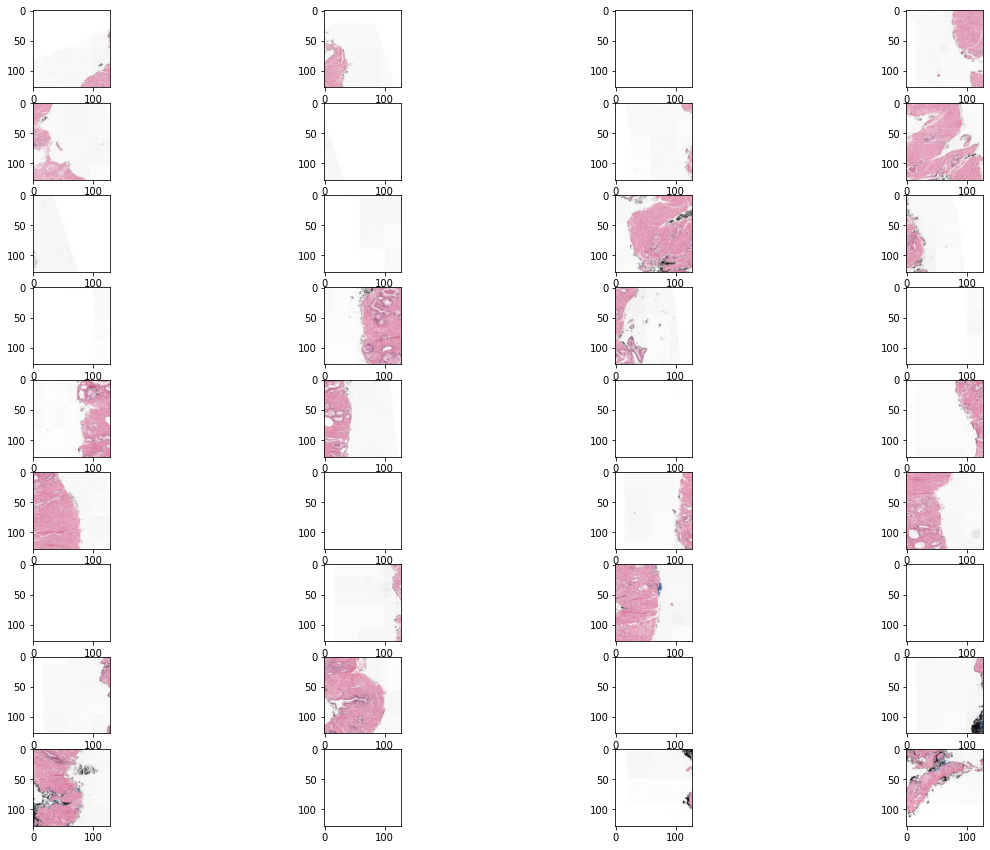

In [ ]:
fig, axes = plt.subplots(9, 4, figsize=(20, 15))
for i in range(36):
  axes[i // 4][i % 4].imshow(patches[i])

In [ ]:
[np.unique(patches[i], return_counts=True) for i in range(36)][34]

(array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
        0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
        0.03921569, 0.04313726, 0.04705882, 0.05098039, 0.05490196,
        0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.07450981,
        0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
        0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
        0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
        0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.15294118,
        0.15686275, 0.16078432, 0.16470589, 0.16862746, 0.17254902,
        0.1764706 , 0.18039216, 0.18431373, 0.1882353 , 0.19215687,
        0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21568628,
        0.21960784, 0.22352941, 0.22745098, 0.23137255, 0.23529412,
        0.23921569, 0.24313726, 0.24705882, 0.2509804 , 0.25490198,
        0.25882354, 0.2627451 , 0.26666668, 0.27058825, 0.27450982,
        0.2784314 , 0.28235295, 0.28627452, 0.29

In [ ]:
mask = openslide.OpenSlide('/content/PANDA_subset/train_masks_subset/81adb00db7e7b3034900a1f95a4dc257_mask.tiff')
mask_data = mask.read_region((0, 0), 2, mask.level_dimensions[2])
mask_data = mask_data.convert('RGB')
mask_data = np.asarray(mask_data, np.float32)
mask_data = mask_data[:, :, 0]

In [ ]:
mask_data.shape

(1568, 464)

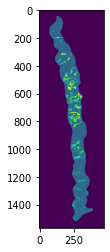

In [ ]:
plt.imshow(mask_data)

In [ ]:
mask_data = tf.expand_dims(mask_data, 0)
mask_data = tf.expand_dims(mask_data, -1)
patches = tf.image.extract_patches(mask_data, (1, 128, 128, 1), (1, 128, 128, 1), (1, 1, 1, 1), 'VALID')
patches = tf.reshape(patches, (-1, 128, 128, 1))
patches.shape

TensorShape([36, 128, 128, 1])

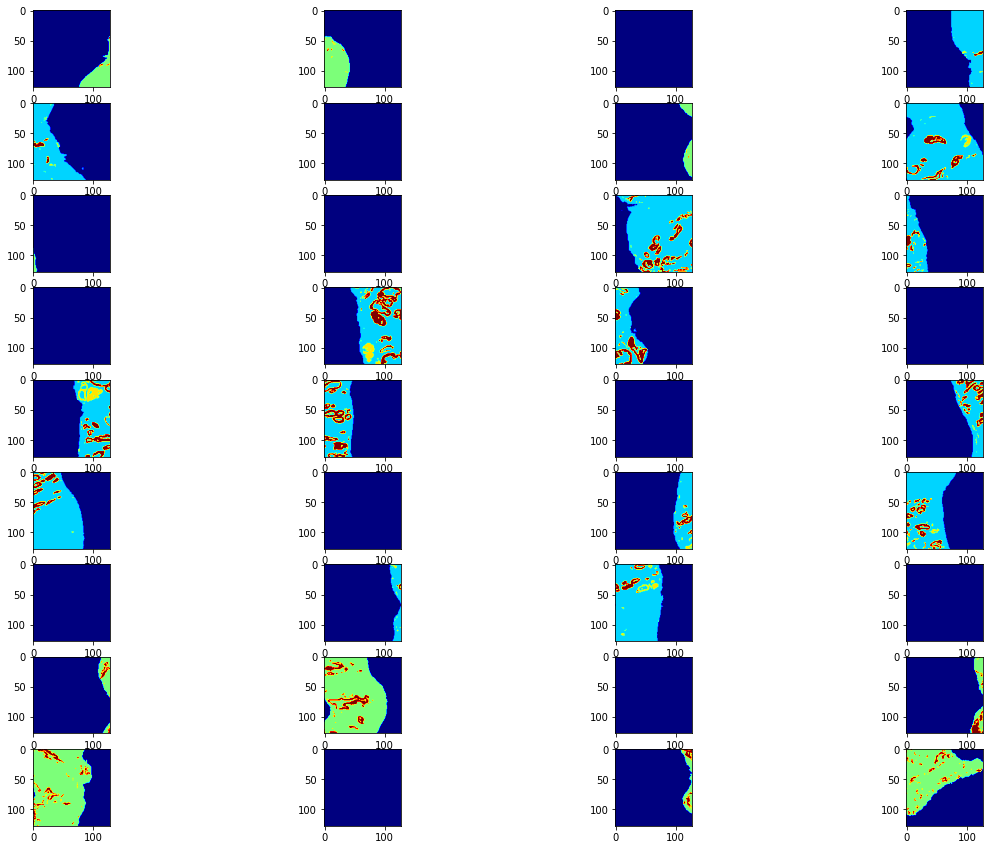

In [ ]:
fig, axes = plt.subplots(9, 4, figsize=(20, 15))
for i in range(36):
  axes[i // 4][i % 4].imshow(tf.squeeze(patches[i]), cmap='jet')

In [ ]:
[np.unique(patches[i], return_counts=True) for i in range(36)]

[(array([0., 1., 2.], dtype=float32), array([14762,  1596,    26])),
 (array([0., 1., 2.], dtype=float32), array([13370,  2982,    32])),
 (array([0.], dtype=float32), array([16384])),
 (array([0., 1., 2., 3.], dtype=float32), array([11489,  4798,    38,    59])),
 (array([0., 1., 2., 3.], dtype=float32), array([10633,  5506,    63,   182])),
 (array([0.], dtype=float32), array([16384])),
 (array([0., 1., 2.], dtype=float32), array([15461,   915,     8])),
 (array([0., 1., 2., 3.], dtype=float32), array([ 2232, 12938,   196,  1018])),
 (array([0., 1., 2.], dtype=float32), array([16231,   151,     2])),
 (array([0.], dtype=float32), array([16384])),
 (array([0., 1., 2., 3.], dtype=float32), array([ 3075, 11642,    25,  1642])),
 (array([0., 1., 2., 3.], dtype=float32), array([13205,  2809,    21,   349])),
 (array([0.], dtype=float32), array([16384])),
 (array([0., 1., 2., 3.], dtype=float32), array([7307, 6581,  421, 2075])),
 (array([0., 1., 2., 3.], dtype=float32), array([11653,  369

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  
  def __init__(self,
               img_dir: str,
               mask_dir: str,
               df_images: pd.DataFrame, 
               batch_size: int, 
               target_size: tuple,
               patch_size: tuple,  
               level: int,
               tissue_threshold = 0.35,
               is_training=True,
               ):
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.df = df_images
    self.target_size = target_size
    self.patch_size = patch_size
    self.batch_size = batch_size
    self.level = level
    self.thresh = tissue_threshold
    self.training = is_training


    self.indices = range(len(self.df))

    self.indexed_df = self.df.copy()
    self.indexed_df.set_index('image_id', inplace=True)
    
    if 0 > self.level > 2:
      raise ValueError(f"level should be in the range [0, 2]")
    


  def __len__(self):
    return len(self.df) // self.batch_size


  def on_epoch_start(self):
    if self.training:
            np.random.shuffle(self.indices)


  def __read_slide(self, image_id: str):
    img_path = f'{self.img_dir}/{image_id}.tiff'
    img = openslide.OpenSlide(img_path)
    img_data = img.read_region((0, 0), self.level, img.level_dimensions[self.level])
    img_data = img_data.convert('RGB')
    img_data = np.asarray(img_data, np.float32) / 255.0
    img_data = tf.expand_dims(img_data, 0)
    img_data = tf.image.resize(img_data, self.target_size)

    img.close()
    
    return img_data
  
  def __read_mask(self, image_id: str):
    mask_path = f'{self.mask_dir}/{image_id}_mask.tiff'
    mask = openslide.OpenSlide(mask_path)
    mask_data = mask.read_region((0, 0), self.level, img.level_dimensions[self.level])
    mask_data = mask_data.convert('RGB')
    mask_data = np.asarray(mask_data, np.float32)
    mask_data = mask_data[:, :, 0]
    if self.indexed_df.loc[image_id]['data_provider'] == 'radboud':
      mask_data[mask_data == 2.0] = 1.0
    mask_data = tf.expand_dims(mask_data, 0)
    mask_data = tf.expand_dims(mask_data, -1)
    mask_data = tf.image.resize(mask_data, self.target_size)

    mask.close()

    return mask_data
  
  def __get_patches(self, batch_images, batch_masks):
    patch = (1, self.patch_size[0], self.patch_size[1], 1)

    batch_patches = tf.image.extract_patches(batch_images, patch, patch, 
                                             [1, 1, 1, 1], padding='VALID')
    
    batch_patches = tf.reshape(batch_patches, (-1, self.patch_size[0], self.patch_size[1], 3))

    batch_mask_patches = tf.image.extract_patches(batch_masks, patch, patch,
                                                  [1, 1, 1, 1], padding='VALID')
    
    batch_mask_patches = tf.reshape(batch_mask_patches, (-1, self.patch_size[0], self.patch_size[1], 1))

    return batch_patches, batch_mask_patches
    


  def __map_patch_labels(self, batch_patches, batch_mask_patches):
    
    tissue_regions_ind = [i for i in range(batch_patches.shape[0]) if len(np.unique(batch_mask_patches[i])) > 1 
                      and np.unique(batch_mask_patches[i], return_counts=True)[1][0] / (self.patch_size[0] * self.patch_size[1]) < (1 - self.thresh)]
    
    tissue_regions = tf.stack(batch_patches[tissue_regions_ind])

    labels = [0 if np.unique(batch_mask_patches[i])[-1] < 2 else 1 for i in tissue_regions_ind]
    labels = tf.stack(labels)

    onehot_labels = ku.to_categorical(labels, num_classes=2, dtype='int32')
    
    return tissue_regions, onehot_labels

    
  def __getitem__(self, idx):
    batch_indices = self.indices[idx * self.batch_size: (idx + 1) * self.batch_size]
    batch_image_ids = self.df['image_id'].iloc[batch_indices].values
    
    batch_image_data = [self.__read_slide(image_id) for image_id in batch_image_ids]
    batch_image_data = tf.squeeze(tf.stack(batch_image_data), 1)

    batch_mask_data = [self.__read_mask(image_id) for image_id in batch_image_ids]
    batch_mask_data = tf.squeeze(tf.stack(batch_mask_data), 1)

    batch_patches, batch_mask_patches = self.__get_patches(batch_image_data, batch_mask_data)

    return self.__map_patch_labels(batch_patches.numpy(), batch_mask_patches.numpy())




In [ ]:
train_datagen = DataGenerator(img_dir=IMAGES_DIR,
                   mask_dir=MASK_DIR,
                   df_images=train_df,
                   batch_size=8,
                   target_size=(1568, 464),
                   patch_size=(128, 128),
                   level=2,
                   tissue_threshold=0.35,
                   is_training=True)

validation_datagen = DataGenerator(img_dir=IMAGES_DIR,
                   mask_dir=MASK_DIR,
                   df_images=validation_df,
                   batch_size=8,
                   target_size=(1568, 464),
                   patch_size=(128, 128),
                   level=2,
                   tissue_threshold=0.35,
                   is_training=False)

# Benchmarking the DataGenerators

In [ ]:
"""Tbc"""

In [ ]:
# test = next(iter(train_datagen))

In [ ]:
model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, 
                                                       input_shape=(128, 128, 3))
def build_model(pre_trained_model: tf.keras.Model) -> tf.keras.Model:
    for layer in pre_trained_model.layers:
        layer.trainable=False
    
    
    
    x = pre_trained_model.outputs[0]
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=[pre_trained_model.inputs], outputs=[outputs], name='baseline_model')
    return model

model = build_model(model)

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, mode='max', restore_best_weights=True, verbose=1
)

model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
             metrics=METRICS)

In [ ]:
history = model.fit(train_datagen, epochs=100, verbose=1, callbacks=[early_stopping], validation_data=validation_datagen)

Epoch 1/100
8/8 [==============================] - 75s 9s/step - loss: 0.6974 - tp: 268.0000 - fp: 202.0000 - tn: 268.0000 - fn: 202.0000 - accuracy: 0.5702 - precision: 0.5702 - recall: 0.5702 - auc: 0.6213 - prc: 0.6178 - val_loss: 0.5819 - val_tp: 69.0000 - val_fp: 33.0000 - val_tn: 69.0000 - val_fn: 33.0000 - val_accuracy: 0.6765 - val_precision: 0.6765 - val_recall: 0.6765 - val_auc: 0.7808 - val_prc: 0.7901
Epoch 2/100
8/8 [==============================] - 23s 3s/step - loss: 0.6715 - tp: 276.0000 - fp: 194.0000 - tn: 276.0000 - fn: 194.0000 - accuracy: 0.5872 - precision: 0.5872 - recall: 0.5872 - auc: 0.6218 - prc: 0.6180 - val_loss: 0.5758 - val_tp: 69.0000 - val_fp: 33.0000 - val_tn: 69.0000 - val_fn: 33.0000 - val_accuracy: 0.6765 - val_precision: 0.6765 - val_recall: 0.6765 - val_auc: 0.7853 - val_prc: 0.7938
Epoch 3/100
8/8 [==============================] - 23s 3s/step - loss: 0.6515 - tp: 289.0000 - fp: 181.0000 - tn: 289.0000 - fn: 181.0000 - accuracy: 0.6149 - precisi

(1, 1856, 448, 3)
Diagnosis: malignant


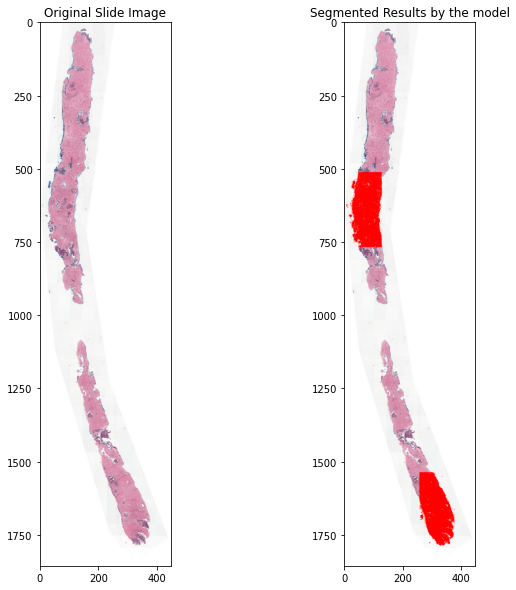

In [ ]:
def get_inference(slide_path: str, index_level: int, model: tf.keras.Model, tissue_thresh=0.35, segmented_results=False):
  img = openslide.OpenSlide(slide_path)
  img_data = img.read_region((0, 0), index_level, img.level_dimensions[index_level])
  img_data = img_data.convert('RGB')
  img_data = np.asarray(img_data, np.float32) / 255.0
  img_data = tf.expand_dims(img_data, 0)
  print(img_data.shape)
  img.close()

  patch = (1, 128, 128, 1)

  batch_patches = tf.image.extract_patches(img_data, patch, patch, 
                                             [1, 1, 1, 1], padding='VALID')
    
  batch_patches = tf.reshape(batch_patches, (-1, 128, 128, 3))

  tissue_regions_ind = [i for i in range(batch_patches.shape[0]) if np.unique(batch_patches[i])[0] < 0.75
                        and np.sum(np.unique(batch_patches[i][batch_patches[i] > 0.75], return_counts=True)[1]) / (128 * 128 * 3) < (1 - tissue_thresh)]
  
  tissue_regions = tf.stack(batch_patches.numpy()[tissue_regions_ind])

  preds = np.argmax(model.predict(tissue_regions), axis=1)
  img_data = np.squeeze(img_data.numpy())
  copy_img_data = img_data.copy()
  loc_ind = img_data.shape[1] // 128
  diagnosis = 'banign'

  if np.sum(preds > 0):
    diagnosis = 'malignant'

  if segmented_results:
    for ind, res in enumerate(tissue_regions_ind):
      if preds[ind] == 1:
        row, col = res // loc_ind, res % loc_ind
        roi = img_data[row * 128 : (row + 1) * 128, col * 128: (col + 1) * 128, :]
        roi[roi[:, :, 0] < 0.93] = (1, 0, 0)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    axes[0].imshow(copy_img_data)
    axes[0].set_title('Original Slide Image')

    axes[1].imshow(img_data)
    axes[1].set_title('Segmented Results by the model')

    
  
  print(f'Diagnosis: {diagnosis}')



get_inference('/content/PANDA_subset/train_images_subset/82b8e31cf5bd59934af005c609d05e64.tiff', 2, model, segmented_results=True)